# Practical work 8: Color quantification and search by content


In this practical work session, we will:

- Develop a color based descriptor that can be applied to every image in a database
- Use this color descriptor to create a method that searches images by content: the goal is to find the images that are the most similar to a query.

In [1]:


# Load useful library kl

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import imageio
import scipy.signal
import scipy.ndimage
from skimage.color import rgb2hsv, hsv2rgb ,rgb2luv, luv2rgb
from matplotlib import cm
from sklearn.cluster import MeanShift, estimate_bandwidth
import cv2

# Usefull functions
def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def setColors(nH, nS, nV):
    """ int**3 -> Array[nH*nS*nV,3]*Array[nH,nS,nV,3]
        computes an RGB palette from a sampling of HSV values
    """
    pal1 = np.zeros((nH*nS*nV, 3))
    pal2 = np.zeros((nH, nS, nV, 3))
    tH, tS, tV = 1/(2*nH), 1/(2*nS), 1/(2*nV)

    idx = 0
    for i in range(nH):
        for j in range(nS):
            for k in range(nV):
                HSVval = np.array([[[i/nH + tH, j/nS + tS, k/nV + tV]]])
                pal1[idx, :] = hsv2rgb(HSVval)*255  
                pal2[i, j, k, :] = hsv2rgb(HSVval)*255
                idx += 1
    return pal1, pal2

def viewQuantizedImage(I,pal):
    """ Array*Array -> Array
        Display an indexed image with colors according to pal 
    """
    Iview = np.empty(I.shape)
    n, m, c = I.shape
    for i in range(n):
        for j in range(m):
            h, s, v = I[i, j, :]
            Iview[i, j, :] = pal[ int(h), int(s), int(v), :]
    return Iview/255

def display5mainColors(histo, pal):
    """ Array*Array -> NoneType
        Display the 5 main colors in histo 
    """
    idx = np.argsort(histo)
    idx = idx[::-1]
    K = 5
    for i in range (K):
        Ia = np.zeros((1, 1, 3), dtype=np.uint8)
        Ia[0,0,0] = pal[idx[i], 0]
        Ia[0,0,1] = pal[idx[i], 1]
        Ia[0,0,2] = pal[idx[i], 2]
        plt.subplot(1, K, i+1)
        plt.imshow(Ia)
        plt.axis('off')
    plt.show()

def display20bestMatches(S, indexQuery):
    """ Array*int -> NoneType 
    """
    L = S[indexQuery, :]
    Idx = np.argsort(L)
    cpt = 1
    plt.figure(figsize=(15, 10))
    for idx in Idx[:20]:
        plt.subplot(5, 4, cpt)
        indexQuery = idx
        imageName = (pathImage+listImage[indexQuery]).strip()
        plt.imshow(np.array(Image.open(imageName))/255.)
        plt.title(listImage[indexQuery])
        plt.axis('off')
        cpt += 1
    plt.show()

def display_gif(fn):
    from IPython import display
    return display.HTML('{}">'.format(fn))



## Exercise 1: HSV histogram computation

Each image of the base will be represented by its color histogram in the HSV representation. We use the HSV representation rather that the RGB representation because it is a perceptual color space: two colors that look similar will have close HSV vectors.

1) Write a function ```iv = quantize(v,K)``` that returns the quantize interval of `v` considering a uniform quantization of values over the range $[0,1]$ with `K` evenly spaced intervals. For a image value v=1, the function will return K-1.

In [2]:
def quantize(v,K):
    return (np.where(v==1, K-1, np.floor(v*K))).astype(int)


# You can test your function with the following lines:
h = np.zeros((8))
for i in range(256):
    h[quantize(i/255.,8)] += 1
assert (h == 32*np.ones((8))).all()

2) Write a function ```[Iq, histo] = quantizeImage(I,Nh,Ns,Nv)``` that takes as input one image I of size N x M x 3 in the HSV representation and the number of quantification interval needed for H, S and V. 
    Your function will return: 
 *    ```Iq```: the quantified image for each channel, of size N x M x 3
 *   ```hist```: a 3D histogram of size Nh x Ns x Nv that counts the number of pixel for each quantification bin (iH, iS, iV)

In [3]:
def quantizeImage(I, nH, nS, nV):
    Iq = np.zeros(I.shape).astype(int)
    Iq[:,:,0] = quantize(I[:,:,0], nH)
    Iq[:,:,1] = quantize(I[:,:,1], nS)
    Iq[:,:,2] = quantize(I[:,:,2], nV)

    Hist = np.zeros((nH, nS, nV))

    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            Hist[Iq[i,j,0], Iq[i,j,1], Iq[i,j,2]] += 1
            
    return Iq,Hist




3) Write a function ```normalized_histo = NormalizeHistL2(histo)``` that applies a normalization on the histogram ```histo``` according to the L2 norm.
The L2 norm of x can be computed using the function ```numpy.linalg.norm(x,2)```



In [4]:


def normalize(H):
    """ Array -> Array"""
    return H/np.linalg.norm(H,2)



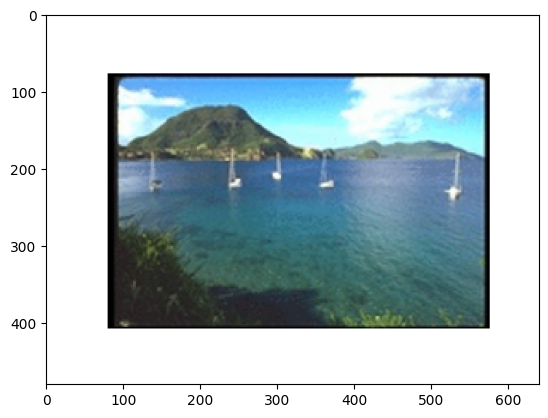

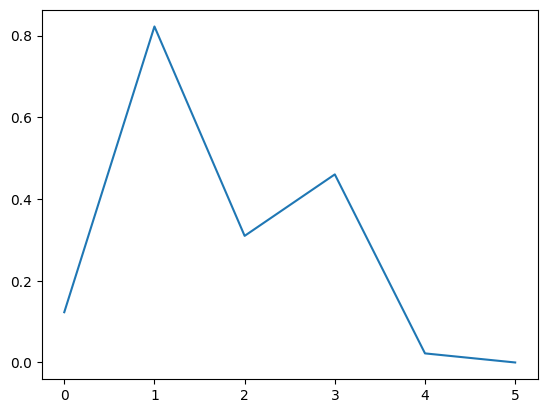

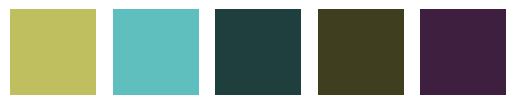

[(0, 0, 1), (1, 0, 1), (1, 0, 0), (0, 0, 0), (2, 0, 0)]


In [5]:

PathImage = './figs/'  # to be completed
nom = 'Figure_1.png'  # to be completed

# quantization parameters
nH = 3
nS = 1
nV = 2


filename= nom;
I = np.array(Image.open(PathImage + filename))[:,:,:3]
I = I / 255.  # I values range in [0,1]
plt.figure();
plt.imshow(I);
plt.show()

# conversion RGB->HSV
J = rgb2hsv(I)

# color palette computation
palette, palette2 = setColors( nH, nS , nV );

# Image quantization (your function)
Iq, histo = quantizeImage(J, nH, nS, nV)

# Visualisation of quantized image
viewQuantizedImage(Iq , palette2)

# flat a 3D histogram to 1D
histo = histo.flat

# Histogram normalization (your function)
histo = normalize(histo)

plt.figure()
plt.plot(histo)
plt.show()

## Determine 5 more frequent colors
idx_most_prevalent = (-histo).argsort()[:5]
hsv_most_prevalent = [np.unravel_index(idx,( nH, nS , nV )) for idx in idx_most_prevalent]

display5mainColors(histo, palette)

print(hsv_most_prevalent)

In [6]:


w,h=400,400
def test_exo_1(I,nH,nS,nV):
    I_hsv=rgb2hsv(I)
    
    Iq,HistoIq=quantizeImage(I_hsv,nH,nS,nV)
    pal1, pal2 = setColors(nH, nS, nV)
   



    Iq_RGB=viewQuantizedImage(Iq,pal2)
    
    histo=normalize(HistoIq.flatten())

    fig = plt.figure(figsize=(w/60,h/60), layout="constrained")
    spec = fig.add_gridspec(6, 6)

    ax0 = fig.add_subplot(spec[0:3, :3])
    ax0.imshow(I)
    ax0.set_title("original")

    ax1 = fig.add_subplot(spec[0:3, 3:])
    ax1.imshow(Iq_RGB)
    ax1.set_title("Quantized")

    ax2 = fig.add_subplot(spec[4:, :])
    ax2.hist(histo,bins=256)
    ax2.set_title("Histogram")

    K = 6
    
    ## Determine 5 more frequent colors
    idx_most_prevalent = (-histo).argsort()[:K]
    hsv_most_prevalent = [np.unravel_index(idx,( nH, nS , nV )) for idx in idx_most_prevalent]


    idx = np.argsort(histo)
    idx = idx[::-1]
    

    for i in range (K):
        Ia = np.zeros((1, 1, 3), dtype=np.uint8)
        Ia[0,0,0] = pal1[idx[i], 0]
        Ia[0,0,1] = pal1[idx[i], 1]
        Ia[0,0,2] = pal1[idx[i], 2]
        ax_tmp = fig.add_subplot(spec[3, i])
        ax_tmp.axis('off')
        ax_tmp.imshow(Ia)



In [7]:
plage=np.array(Image.open("./figs/Figure_1.png"))[75:330,75:500,:3]

In [8]:
print(plage.shape)

(255, 425, 3)


5) Change the values of ```nH```, ```nS```  and ```nV``` and analyze the results. You can try with other images in the base.

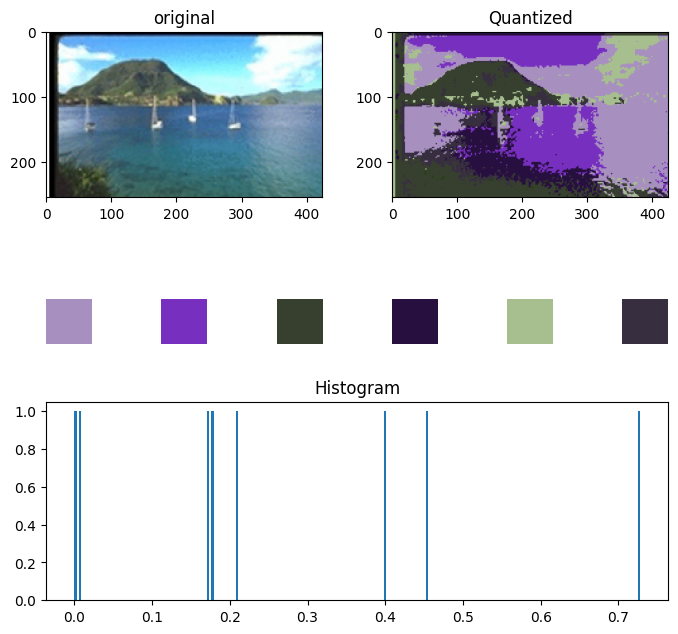

In [9]:
test_exo_1(plage,2,2,2)

6) What can you say about the results?

Your answer: ............

## Exercise 2: Similarity between images: 

In this exercice, we will compute a measure of similarity between two images from the normalized histogram. This measure of similarity will be used in order to find images that are the most similar to a given image.

### Question 2.1:  Computation of the histograms for the whole base

Complete the following script to compute the histograms for every image in the base. As the computation can take a lot of time, we will do it only one time and store the result in ```ListHisto.mat```. The results will be stored as a ```N x M``` array ```listHisto``` with ```N = 1040``` and ```M = nH x nS x nV ```. We will also save the names of the images as ```listImage```

Set ```bcomputed = False``` for the first run to compute the database histograms and then set it to 1.


In [52]:
import os
from scipy.io.matlab.mio import loadmat, savemat

#####

pathImage = './Base/'
pathDescriptors = './'

# Quantization HSV
nH = 3
nS = 3
nV = 3

bcomputed = False# Set to False to compute the histogramm database

if not bcomputed:
    listImage = os.listdir(pathImage)
    listHisto = []
    print('Histogram database computation ... it may take a while ...')
    for imageName in listImage:
        if os.path.isfile(pathImage+imageName) and imageName[-4:] == '.png':
            print( imageName)
            
            if (imageName=='._Liontigre20.png'):
                continue
            # read image
            I = np.array(Image.open(pathImage+imageName)) / 255.

            # conversion RGB->HSV
            J = rgb2hsv(I);
            # Image quantization (your function tested in Exo 1)
            _,histo = quantizeImage(J, nH, nS, nV)
  
            # flat a 3D histogram in 1D
            histo = histo.flatten()
            
            # Normalize histogramme (your function tested in Exo 1)
            listHisto.append(normalize(histo))

    print(len(listHisto), "histograms computed")
    nomList = pathDescriptors+'ListHisto.mat'
    savemat(nomList, {'listHisto': np.array(listHisto),
                      'listImage': np.array(listImage)})
else:
    print("Histogram database computation already done.")

/tmp/ipykernel_127522/623329054.py:2: DeprecationWarning: Please use `loadmat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat
/tmp/ipykernel_127522/623329054.py:2: DeprecationWarning: Please use `savemat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat


Histogram database computation ... it may take a while ...
Textures48.png
Ours__67.png
Voitures92.png
Textures95.png
Avions100.png
Voitures61.png
Voitures76.png
Paysages97.png
Portraits68.png
Avions58.png
Fleche32.png
Avions62.png
Textures26.png
Bestioles15.png
Liontigre72.png
Bestioles32.png
Fleche42.png
Avions98.png
Ours__46.png
Textures50.png
Avions19.png
Textures12.png
Elephant37.png
Avions28.png
Paysages34.png
Ours__11.png
Bestioles5.png
Aeriennes24.png
Voitures82.png
Paysages31.png
Portraits64.png
Liontigre5.png
Voitures85.png
Voitures40.png
Paysages41.png
Ours__43.png
Bestioles59.png
Elephant41.png
Voitures69.png
Bestioles8.png
Elephant92.png
Ours__34.png
Sunsets82.png
Sunsets68.png
Liontigre89.png
Textures27.png
Textures41.png
Ours__54.png
Liontigre53.png
Liontigre103.png
Sunsets63.png
Textures102.png
Portraits65.png
Voitures36.png
Liontigre84.png
Textures125.png
Bestioles4.png
Fleche39.png
Aeriennes12.png
Elephant42.png
Aeriennes28.png
Voitures7.png
Fleche19.png
Textures151.pn

Paysages90.png
Elephant94.png
Paysages13.png
Portraits29.png
Aeriennes19.png
Ours__26.png
Paysages52.png
Liontigre68.png
Ours__37.png
Paysages80.png
Paysages33.png
Paysages37.png
Fleche37.png
Ours__35.png
Sunsets57.png
Liontigre33.png
Voitures64.png
Bestioles58.png
Liontigre12.png
Fleche33.png
Bestioles44.png
Bestioles6.png
Textures66.png
Sunsets76.png
Avions96.png
Voitures53.png
Elephant63.png
Ours__39.png
Textures69.png
Bestioles56.png
Voitures90.png
Voitures47.png
Sunsets92.png
Textures174.png
Paysages50.png
Textures93.png
Fleche5.png
Paysages83.png
Paysages11.png
Textures57.png
Paysages1.png
Sunsets91.png
Liontigre2.png
Sunsets80.png
Paysages81.png
Avions49.png
Paysages68.png
Textures145.png
Ours__15.png
Voitures62.png
Elephant30.png
Liontigre80.png
Voitures29.png
Paysages28.png
Voitures22.png
Textures141.png
Liontigre50.png
Fleche15.png
Paysages30.png
Fleche6.png
Elephant91.png
Ours__8.png
Avions70.png
Elephant4.png
Paysages14.png
Voitures74.png
Avions60.png
Textures32.png
Voiture

### Question 2.2: Computation of the similarity between every images in the base.

   1. Write a function ```similarityMatrix()``` or a script that performs the similarity computation for every pair of images in the base from the histograms stored in ```listHisto``` and store the result in a ```1024 x 1024``` matrix ```S```. It is possible to make the operation much faster by using only one matrix operation.

In [139]:
b=np.array([[[1,1],[2,2],[3,3],[4,4]]])

#np.tile(a,4).reshape(4,4,1)
np.transpose(b,(1,0,2))
#np.tile(b[:],3)

array([[[1, 1]],

       [[2, 2]],

       [[3, 3]],

       [[4, 4]]])

In [144]:
mat = loadmat(pathDescriptors+'ListHisto.mat')
listHisto = mat['listHisto']
listImage = mat['listImage']

def similarityMatrix(T) :
    T1=T.copy()
    
    T1=np.tile(T1,T.shape[0]).reshape(T.shape[0],T.shape[0],T.shape[1])
    
    T2=T1.copy()
    T2=np.transpose(T2,(1,0,2))
  
    return np.sqrt(np.sum(np.square(T2-T1),axis=2))
    

In [145]:
b=np.array([[1,1],[2,2],[3,3],[4,4]])

tableau_resultat=similarityMatrix(listHisto)

Text(0.5, 1.0, 'original')

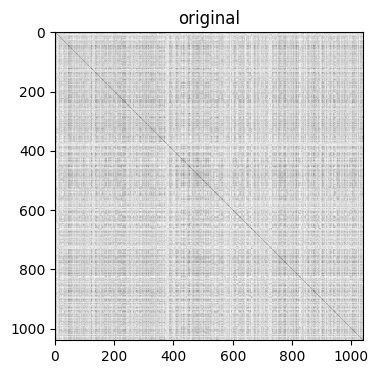

In [146]:
fig = plt.figure(figsize=plt.figaspect(0.25))
    
ax = fig.add_subplot(1, 1, 1)
ax.imshow(tableau_resultat,cmap="gray")
ax.set_title("original")
    
    

2. Display the matrix `S`  as an image. What can we say about this it ?

Your answer: ..................

3. Assuming `S` is already computed and using function `display20bestMatches()`, test on the image `Liontigre1.png` (indexQuery = 349). You should obtain something similar to Figure 5.

![figure5.png](./figs/Figure_5.png)
<center>Figure 5: 20 best matches of image 'Liontigre1.png'</center>

In [ ]:
# a supprimer je pense !!!!
indexQuery = 349
display20bestMatches(S, indexQuery)
imageName = (pathImage+NomImageBase[indexQuery]).strip()


4. Assuming `S` is already computed, generate a random query (an integer in range $[0, 1030]$), and display the 20 best matches.


In [ ]:
import random


5. What can you say about the results ? What are the limitations and the advantages of this method ?

Your answer: ..........